
# Shared rides with pricing - Delft 

 ### Choice Function (Deterministic):
 `pool_price.py`
 * Pickup Distance: distance from driver initial position to the first pickup point
 * Travel Distance: distance from driver's initial position to the drop off point of the last passenger
 * Operating Cost: This include all the expenses
 * Profit: Driver revenue to serve the request
            
 
  ### KPI:
   
   * Profit of Individual driver
   * Profit of all the drivers
   * No.of rejected rides
   * U - PAX (Utility) 
  
   ### TBD- Choice Function (Probablistic):
  
  * choice logic to be applied inside `pool_price.py` 
  * P(R)= exp(beta * Profit_R)/ sum_all the rides( exp(beta * Profit_R)
 



In [41]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging
import matplotlib.pyplot as plt

import pandas as pd
import ExMAS


## Pricing for Delft, Netherlands

In [43]:
params = get_config('../../data/config/delft.json')  # load configuration

params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 10 # reuqests (and passengers)
params.nV = 10 # vehicles

## Parameters for ExMAS

In [44]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

inData = load_G(inData, params)  # load network graph 

inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 


08-02-23 20:53:03-INFO-Initializing pairwise trip shareability between 10 and 10 trips.
08-02-23 20:53:03-INFO-creating combinations
08-02-23 20:53:03-INFO-90	 nR*(nR-1)
08-02-23 20:53:03-INFO-Reduction of feasible pairs by 95.56%
08-02-23 20:53:03-INFO-Degree 2 	Completed
08-02-23 20:53:03-INFO-trips to extend at degree 2 : 8
08-02-23 20:53:03-INFO-At degree 2 feasible extensions found out of 2 searched
08-02-23 20:53:03-INFO-Degree 3 	Completed
08-02-23 20:53:03-INFO-trips to extend at degree 3 : 2
08-02-23 20:53:03-INFO-At degree 3 feasible extensions found out of 0 searched
08-02-23 20:53:03-INFO-Degree 4 	Completed
08-02-23 20:53:03-INFO-Max degree reached 4
08-02-23 20:53:03-INFO-Trips still possible to extend at degree 4 : 0


In [45]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

08-02-23 20:53:03-INFO-Matching 10 trips to 20 rides in order to min u_pax
08-02-23 20:53:03-INFO-Problem solution: Optimal. 
Total costs for single trips:             50 
reduced by matching to:                   48


In [46]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],3.195500,172,1,[3.1955],"[0, 172]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44789407, 4261101530]","[None, 0, 0]",node time req_id od 0 ...,172,1.72,2.59350,0.51870,2.07480
1,[1],5.947500,321,1,[5.9475],"[29, 321]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1404945936, 4846026451]","[None, 1, 1]",node time req_id od 0 ...,321,3.21,4.82400,0.96480,3.85920
2,[2],9.223500,498,1,[9.2235],"[77, 498]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1566353937, 5171908140]","[None, 2, 2]",node time req_id od 0 ...,498,4.98,7.48050,1.49610,5.98440
3,[3],1.962500,106,1,[1.9625],"[94, 106]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1679761156, 44785094]","[None, 3, 3]",node time req_id od 0 ...,106,1.06,1.59150,0.31830,1.27320
4,[4],3.177000,171,1,[3.177],"[105, 171]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44897712, 2175715314]","[None, 4, 4]",node time req_id od 0 ...,171,1.71,2.57850,0.51570,2.06280
5,[5],4.119000,222,1,[4.119],"[148, 222]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1,"[None, 44766586, 1518087848]","[None, 5, 5]",node time req_id od 0 ...,222,2.22,3.34200,0.66840,2.67360
6,[6],6.791000,367,1,[6.791],"[174, 367]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1,"[None, 1570982849, 1519889830]","[None, 6, 6]",node time req_id od 0 ...,367,3.67,5.50650,1.10130,4.40520
7,[7],7.190000,388,1,[7.1899999999999995],"[192, 388]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[None, 44861489, 1608998204]","[None, 7, 7]",node time req_id od 0 ...,388,3.88,5.83200,1.16640,4.66560
8,[8],3.103000,167,1,[3.1029999999999998],"[217, 167]",[8],[8],1,8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,"[None, 44810830, 1571093185]","[None, 8, 8]",node time req_id od 0 ...,167,1.67,2.51850,0.50370,2.01480
9,[9],6.004500,324,1,[6.0045],"[264, 324]",[9],[9],1,9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44844082, 5315003498]","[None, 9, 9]",node time req_id od 0 ...,324,3.24,4.87050,0.97410,3.89640


## Simulation with MaaSSim 

In [60]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

08-02-23 21:01:35-WARNING-Setting up 0.1h simulation at 2023-02-08 20:51:06 for 10 vehicles and 10 passengers in Delft, Netherlands
08-02-23 21:01:35-CRITICAL-this is request 0 with [0, 14] available rides.
08-02-23 21:01:35-CRITICAL-ride 0 available [1]
08-02-23 21:01:35-CRITICAL-ride 14 available [0, 1]
08-02-23 21:01:35-CRITICAL-this is reuqest 0 with [0, 14] still available rides.
08-02-23 21:01:35-CRITICAL-vehicle 1 has 2 choices
08-02-23 21:01:35-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 0 of degree 1, with travellers [0].
08-02-23 21:01:35-CRITICAL-this is request 1 with [1, 10, 11, 14, 15, 16, 18, 19] available rides.
08-02-23 21:01:35-CRITICAL-ride 1 available [1]
08-02-23 21:01:35-CRITICAL-ride 10 available [1, 0]
08-02-23 21:01:35-CRITICAL-ride 11 available [0, 1]
08-02-23 21:01:35-CRITICAL-ride 14 not available [1, 3]
08-02-23 21:01:35-CRITICAL-ride 15 available [1, 0]
08-02-23 21:01:35-CRITICAL-ride 16 available [0, 1]
08-02-23 21:01:35-CRITICAL-ride 18 

In [61]:
sim.res[0].pax_exp


,ACCEPTS_OFFER,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,
0,15.0,172.0,6.0,30.0,517.0,14.0,0.0,10.0,0,0,0,0,0,0,172.0,531.0,55.0
1,15.0,435.0,35.0,30.0,313.0,0.0,14.0,10.0,0,0,0,0,0,0,435.0,313.0,55.0
2,15.0,608.0,18.0,30.0,65.0,2.0,77.0,10.0,0,0,0,0,0,0,608.0,67.0,55.0
3,15.0,106.0,35.0,30.0,250.0,77.0,2.0,10.0,0,0,0,0,0,0,106.0,327.0,55.0
4,15.0,271.0,20.0,28.0,50.0,2.0,105.0,10.0,0,0,0,0,0,0,271.0,52.0,53.0
5,15.0,222.0,20.0,30.0,80.0,0.0,148.0,10.0,0,0,0,0,0,0,222.0,80.0,55.0
6,15.0,367.0,20.0,30.0,306.0,0.0,174.0,10.0,0,0,0,0,0,0,367.0,306.0,55.0
7,15.0,500.0,35.0,30.0,119.0,105.0,72.0,10.0,0,0,0,0,0,0,500.0,224.0,55.0
8,15.0,167.0,20.0,30.0,130.0,0.0,217.0,10.0,0,0,0,0,0,0,167.0,130.0,55.0


In [62]:
sim.res[0].veh_exp

,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT,TRAVEL,WAIT,CRUISE,OPERATIONS,IDLE,PAX_KM,REVENUE,nREJECTS
veh,,,,,,,,,,,,,,,,,,,,,
1,2.0,0.0,False,0,0,0.0,15.0,0,49.0,0,...,0,6717.0,260.0,0,458.0,124.0,5875.0,4.945,4.15380,NaN
2,2.0,0.0,False,0,0,105.0,15.0,0,27.0,0,...,0,6683.0,500.0,0,169.0,102.0,5912.0,5.607,4.66560,NaN
3,1.0,0.0,False,0,0,217.0,15.0,0,20.0,0,...,0,6980.0,167.0,0,130.0,65.0,6618.0,1.679,2.01480,NaN
4,2.0,0.0,False,0,0,77.0,15.0,0,37.0,0,...,0,6744.0,406.0,0,220.0,112.0,6006.0,6.048,5.08032,NaN
5,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000,NaN
6,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000,NaN
7,1.0,0.0,False,0,0,264.0,15.0,0,20.0,0,...,0,6583.0,324.0,0,323.0,65.0,5871.0,3.247,3.89640,NaN
8,1.0,0.0,False,0,0,174.0,15.0,0,20.0,0,...,0,6647.0,367.0,0,306.0,65.0,5909.0,3.671,4.40520,NaN
9,1.0,0.0,False,0,0,148.0,15.0,0,20.0,0,...,0,7044.0,222.0,0,80.0,65.0,6677.0,2.228,2.67360,NaN


In [63]:
sim.res[0].all_kpi # All driver revenue 

26.889719999999997

In [64]:
sim.res[0].veh_exp['REVENUE'].to_list()

[4.1537999999999995,
 4.6655999999999995,
 2.0148,
 5.080319999999999,
 0.0,
 0.0,
 3.8964,
 4.4052,
 2.6736000000000004,
 0.0]

In [52]:

list(sim.vehs.keys())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [53]:
sim.res[0].all_kpi

26.889719999999997

## Plotting Graph of driver vs revenue

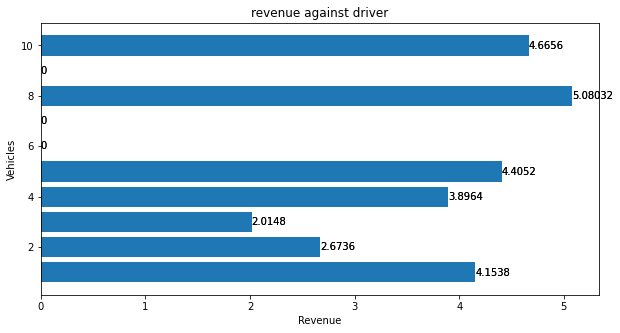

In [54]:
# plot graph of driver revenue
vehicles  = list(sim.res[0].veh_exp.index.to_list())
revenues = sim.res[0].veh_exp['REVENUE'].to_list()
fig, ax = plt.subplots(figsize = (10,5))
bars = ax.barh(vehicles, revenues)
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)


plt.xlabel("Revenue")
plt.ylabel("Vehicles")
plt.title("revenue against driver")
plt.show()

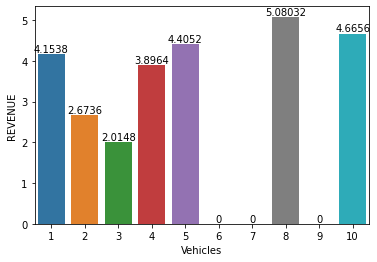

In [55]:
import seaborn as sns
sim.res[0].veh_exp['Vehicles'] = sim.res[0].veh_exp.index

ax =sns.barplot(data=sim.res[0].veh_exp, x="Vehicles", y="REVENUE")
for i in ax.containers:
    ax.bar_label(i,)